## Roll numbers:

- Samaksh Ujjawal: 2024702013
- Soham Patil: 2024701005

# Task 1 : Extrinsic Estimation (20 Points)

You are given 5 images in the `data/Images` folder, and their corresponding 2d-3d correspondences in `data/Correspondences`. Use this information with the Ceres Solver to optimize for the extrinsic of each image using Reprojection Loss.

### Camera Intrinsics:
`fx` = `fy` = 721.5
 
`cx` and `cy` : $\frac{width}{2}$ and $\frac{height}{2}$

### Format for Correspondences:
`px py X Y Z i`
where: `p_x` and `p_y` are the 2d image coordinates, and `X`, `Y` and `Z` are the coordinates of the 3d correspondence for the 2d coordinate, and `i` is the 3d point's index in the pointcloud (you can ignore i, just use the rest of the information as is).


### Resources:
http://ceres-solver.org/nnls_solving.html <br> 
http://ceres-solver.org/nnls_modeling.html <br> 
http://ceres-solver.org/nnls_tutorial.html <br> 

In [1]:
## Refer task1.cc file

# Task 2 : Two-View Geometry Task (35 Points)

### Note:  Use images in folder data_Q2  and the file `data_Q2/intrinsics.txt` has camera intrinsics 
### Don't use Opencv functions unless explicitly mentioned. 

<img src="data_Q2/first_img.jpg" alt="image 1" width="400"/> 
<img src="data_Q2/second_img.jpg" alt="image 2" width="400"/> 

### 1. Feature Extraction and Matching
   **Implement a function to detect and match feature points between two images using OpenCV's SIFT or ORB.**  
   Visualize the matched points and filter outliers using RANSAC. 
   
   Theory : How do you ensure that the matches are accurate, and what thresholding techniques do you apply?

### 2. Fundamental Matrix Estimation
   **Write a function `compute_fundamental_matrix` to estimate the fundamental matrix using the 8-point algorithm.**  
   Normalize the points before estimating and check the rank of the matrix. Explain why normalization is essential in this context.
   
   Extend this to include the 7-point algorithm, and compare the accuracy of the two methods on your matched points.

### 3. Epipolar Lines Visualization
   **Write a function to plot epipolar lines on both images given the estimated fundamental matrix.**  
   For each matched feature in the first image, compute and draw the corresponding epipolar line in the second image.

   Theory (not part of bonus) : What methods can you use to verify that the epipolar lines are accurate?

### 4. Epipole Computation
   **Implement a function to calculate the epipoles from the fundamental matrix.**  
   Verify their correctness by showing that epipolar lines intersect at these points.

   Theory : What happens to the epipole location if the fundamental matrix is rank-deficient, and how can you simulate this scenario?

### 5. Camera Pose from Fundamental Matrix
   **Write a function `camera_pose_from_fundamental` to compute the four possible camera poses (rotation `R` and translation `t`) from the fundamental matrix and intrinsic matrix `K`.**

   Theory (not part of bonus) : Explain why there are four possible solutions and how to verify which is the correct one.

### 6. Triangulation of 3D Points
   **Implement linear triangulation in a function `linear_triangulation` that takes the projection matrices and point correspondences to compute 3D points.**

   Visualize the triangulated points in 3D and describe how the accuracy of 3D points depends on the quality of the fundamental matrix and camera pose.

### 7. Cheirality Condition
   **Write a function `check_cheirality` to ensure that the triangulated 3D points satisfy the cheirality condition for a given camera pose.**

   Use this function to select the correct camera pose among the four possibilities by maximizing the number of points that satisfy the cheirality condition.


### 8. Fundamental Matrix Validation
   **Write a function `validate_fundamental_matrix` to validate the estimated fundamental matrix by checking the epipolar constraint for a set of matched points.**  
   Calculate the residual error for each point pair and analyze the overall error.

   Theory : What threshold should you use to determine if a point satisfies the constraint?

### 9. Camera Pose Visualization
   **Use a 3D plotting library to visualize the computed camera poses and triangulated points in 3D space.**  
   Write a function that takes in camera poses and 3D points and plots them.

   Experiment with different camera poses and triangulated points to observe how pose selection affects the scene structure.

### 10. Error Analysis for Two-view Geometry
   **Implement a function to calculate and plot the reprojection error for triangulated 3D points.**  
   Measure the difference between original 2D points and the reprojected points on both images.

   Theory : How does this error analysis help in refining the camera pose selection?


### Bonus : All theory questions are part of bonus unless mentioned explicitly. (15 Points)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import open3d as o3d

def normalize_points(points):
    mean = np.mean(points, axis=0)
    std = np.std(points)
    transform = np.array([
        [1/std, 0, -mean[0]/std],
        [0, 1/std, -mean[1]/std],
        [0, 0, 1]
    ])
    
    homogeneous_points = np.hstack((points, np.ones((points.shape[0], 1))))
    normalized = (transform @ homogeneous_points.T).T
    return normalized[:, :2], transform

import numpy as np

def compute_fundamental_matrix(points1, points2, use_7_point=False):
    norm_points1, transform1 = normalize_points(points1)
    norm_points2, transform2 = normalize_points(points2)
    
    A = np.array([
        [x2 * x1, x2 * y1, x2, y2 * x1, y2 * y1, y2, x1, y1, 1]
        for (x1, y1), (x2, y2) in zip(norm_points1, norm_points2)
    ])
    
    _, _, Vh = np.linalg.svd(A)
    F1 = Vh[-1].reshape(3, 3)
    F2 = Vh[-2].reshape(3, 3)
    
    if use_7_point:
        coeffs = [
            np.linalg.det(F1 - F2),
            2 * np.linalg.det(F1) - np.trace(F1 @ F2),
            np.linalg.det(F2),
            0
        ]
        roots = np.roots(coeffs)
        solutions = []
        for root in roots:
            if np.isreal(root):
                F_tmp = root * F1 + (1 - root) * F2
                U, S, Vh = np.linalg.svd(F_tmp)
                S[2] = 0
                F_tmp = U @ np.diag(S) @ Vh
                F_tmp = transform2.T @ F_tmp @ transform1
                solutions.append(F_tmp)
        return solutions
    else:
        U, S, Vh = np.linalg.svd(F1)
        S[2] = 0
        F = U @ np.diag(S) @ Vh
        F = transform2.T @ F @ transform1
        return F

def normalize_points(points):
    mean = np.mean(points, axis=0)
    std = np.std(points)
    transform = np.array([
        [1/std, 0, -mean[0]/std],
        [0, 1/std, -mean[1]/std],
        [0, 0, 1]
    ])
    norm_points = (points @ transform[:2, :2].T) + transform[:2, 2]
    return norm_points, transform


def match_features(img1, img2):
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    
    matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = sorted(matcher.match(des1, des2), key=lambda x: x.distance)[:400]
    
    points1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    points2 = np.float32([kp2[m.trainIdx].pt for m in matches])
    
    H, mask = cv2.findHomography(points1, points2, cv2.RANSAC, 4.0)
    inliers = mask.ravel().astype(bool)
    
    return points1, points2, points1[inliers], points2[inliers]

def plot_matches(img1, img2, points1, points2, inlier_points1=None, inlier_points2=None):
    combined_img = np.hstack((img1, img2))
    points2_shifted = points2.copy()
    points2_shifted[:, 0] += img1.shape[1]

    plt.figure(figsize=(15, 10))
    plt.imshow(combined_img, cmap='gray')
    plt.axis('off')

    for pt1, pt2 in zip(points1, points2_shifted):
        plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], 'y-', linewidth=0.5)

    if inlier_points1 is not None and inlier_points2 is not None:
        inlier_points2_shifted = inlier_points2.copy()
        inlier_points2_shifted[:, 0] += img1.shape[1]
        
        for pt1, pt2 in zip(inlier_points1, inlier_points2_shifted):
            plt.scatter([pt1[0], pt2[0]], [pt1[1], pt2[1]], c='cyan', s=25, edgecolors='blue')
            plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], 'r-', linewidth=1)

    plt.show()

def compute_corresponding_epilines(points, which_image, F):
    if which_image == 2:
        F = F.T
    points_h = np.column_stack((points, np.ones(points.shape[0])))
    lines = points_h @ F.T
    norms = np.sqrt(lines[:, 0]**2 + lines[:, 1]**2)
    lines /= norms[:, np.newaxis]

    return lines
def visualize_epipolar_geometry(img1, img2, points1, points2, F):
    def draw_epipolar_lines(img, lines, points):
        img_with_lines = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        height, width = img_with_lines.shape[:2]
        for r in lines:
            x0, y0 = int(0), int(-r[2] / r[1])
            x1, y1 = int(width), int(-(r[2] + r[0] * width) / r[1])
            cv2.line(img_with_lines, (x0, y0), (x1, y1), (0, 0, 255), 4)
        for pt in points:
            center = tuple(pt.astype(int))
            cv2.circle(img_with_lines, center, 15, (255, 255, 255), -1) 
            cv2.circle(img_with_lines, center, 15, (255, 0, 0), 1)
        return img_with_lines

    lines1 = compute_corresponding_epilines(points2, 2, F)
    img1_with_lines = draw_epipolar_lines(img1, lines1, points1)

    lines2 = compute_corresponding_epilines(points1, 1, F)
    img2_with_lines = draw_epipolar_lines(img2, lines2, points2)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img1_with_lines, cv2.COLOR_BGR2RGB))
    plt.title('Epipolar Lines in Image 1')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img2_with_lines, cv2.COLOR_BGR2RGB))
    plt.title('Epipolar Lines in Image 2')
    plt.axis('off')

    plt.show()

def compute_epipoles(F):
    U, S, Vt = np.linalg.svd(F)
    e1 = Vt[-1, :]
    e1 = e1 / e1[2]
    e1 = e1[:2]
    U, S, Vt = np.linalg.svd(F.T)
    e2 = Vt[-1, :]
    e2 = e2 / e2[2]
    e2 = e2[:2]
    return e1, e2

def plot_epipoles_and_epilines_for_image(ax, img, epipole, color, pts, lines_F, title):
    pts = np.array(pts)
    if pts.ndim == 3:
        pts = pts.reshape(-1, 2)

    ax.imshow(img, cmap='gray')
    ax.scatter([epipole[0]], [epipole[1]], color=color, s=100)
    epilines = compute_corresponding_epilines(pts, 2 if lines_F is F.T else 1, lines_F)
    
    for r in epilines:
        x0, y0 = map(int, [epipole[0], epipole[1]])
        x1, y1 = map(int, [0, -r[2] / r[1]])
        x2, y2 = map(int, [img.shape[1], -(r[2] + r[0] * img.shape[1]) / r[1]])
        ax.plot([x0, x2], [y0, y2], color=color, linewidth=0.5)
        ax.plot([x0, x1], [y0, y1], color=color, linewidth=0.5)
    
    ax.set_xlim(min(0, epipole[0] - 50), max(img.shape[1], epipole[0] + 50))
    ax.set_ylim(max(img.shape[0], epipole[1] + 50), min(0, epipole[1] - 50))
    ax.set_title(title)

def plot_epipoles_and_epilines(image1, image2, points1, points2, F):
    epipole1, epipole2 = compute_epipoles(F)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    plot_epipoles_and_epilines_for_image(ax1, image1, epipole1, 'red', points1, F.T, 'Epipole & Epilines (Image 1)')
    plot_epipoles_and_epilines_for_image(ax2, image2, epipole2, 'blue', points2, F, 'Epipole & Epilines (Image 2)')
    
    plt.tight_layout()
    plt.show()

def get_camera_poses(F, K):
    E = K.T @ F @ K
    U, S, Vh = np.linalg.svd(E)
    
    if np.linalg.det(U @ Vh) < 0:
        Vh = -Vh
        
    W = np.array([[0, -1, 0],
                  [1, 0, 0],
                  [0, 0, 1]])
    
    R1 = U @ W @ Vh
    R2 = U @ W.T @ Vh
    t = U[:, 2]
    
    if np.linalg.det(R1) < 0:
        R1, t = -R1, -t
    if np.linalg.det(R2) < 0:
        R2, t = -R2, -t
    
    return [(R1, t), (R1, -t), (R2, t), (R2, -t)]

def triangulate_points(P1, P2, points1, points2):
    points_3d = []
    
    for (x1, y1), (x2, y2) in zip(points1, points2):
        A = np.zeros((4, 4))
        A[0] = x1 * P1[2] - P1[0]
        A[1] = y1 * P1[2] - P1[1]
        A[2] = x2 * P2[2] - P2[0]
        A[3] = y2 * P2[2] - P2[1]
        
        _, _, Vh = np.linalg.svd(A)
        point_3d = Vh[-1]
        points_3d.append(point_3d[:3] / point_3d[3])
    
    return np.array(points_3d)

def check_cheirality(points_3d, R, t):
    transformed_points = (R @ points_3d.T + t.reshape(3, 1)).T
    valid_points = np.sum((points_3d[:, 2] >  0) & (transformed_points[:, 2] >  0))
    return valid_points

def select_best_pose_and_validate(poses, intrinsics, points1, points2, F):
    P1 = intrinsics @ np.hstack((np.eye(3), np.zeros((3, 1))))
    best_pose = None
    max_valid_points = 0
    best_points_3d = None
    
    for R, t in poses:
        P2 = intrinsics @ np.hstack((R, t.reshape(3, 1)))
        points_3d = triangulate_points(P1, P2, points1, points2)
        valid_points = check_cheirality(points_3d, R, t)
        
        if valid_points > max_valid_points:
            max_valid_points = valid_points
            best_pose = (R, t)
            best_points_3d = points_3d

    F_error = validate_fundamental_matrix(F, points1, points2)
    return best_pose[0], best_pose[1], best_points_3d, F_error

def visualize_scene(points_3d, R, t):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points_3d)

    camera1_center = np.zeros(3)
    camera2_center = -R.T @ t

    camera1 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.05)
    camera2 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.05)
    camera1 = camera1.rotate(np.eye(3)).translate(camera1_center)
    camera2 = camera2.rotate(R.T).translate(camera2_center)

    o3d.visualization.draw_geometries([pcd, camera1, camera2])

def visualize_points(points_3d):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points_3d)
    o3d.visualization.draw_geometries([pcd])

def validate_fundamental_matrix(F, points1, points2):
    points1_h = np.column_stack((points1, np.ones(points1.shape[0])))
    points2_h = np.column_stack((points2, np.ones(points2.shape[0])))

    errors = np.abs(np.sum(points2_h * (F @ points1_h.T).T, axis=1))
    return errors.mean()

def calculate_reprojection_error(points_3d, points_2d, P):
    points_3d_homogeneous = np.hstack((points_3d, np.ones((points_3d.shape[0], 1))))
    reprojected_points = (P @ points_3d_homogeneous.T).T
    reprojected_points /= reprojected_points[:, 2:3]
    return np.linalg.norm(points_2d - reprojected_points[:, :2], axis=1)

def plot_reprojected_points(img, original_points, reprojected_points, title):
    plt.figure(figsize=(10, 8))
    plt.imshow(img, cmap='gray')
    plt.scatter(original_points[:, 0], original_points[:, 1], color='red', label='Original Points', s=30)
    plt.scatter(reprojected_points[:, 0], reprojected_points[:, 1], color='blue', label='Reprojected Points', s=30)
    
    for orig, reproj in zip(original_points, reprojected_points):
        plt.plot([orig[0], reproj[0]], [orig[1], reproj[1]], color='yellow', linewidth=0.5)

    plt.title(title)
    plt.legend()
    plt.axis('off')
    plt.show()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


1. Extracting and matching features...
 - Total matches found: 400
 - Inliers after RANSAC: 56


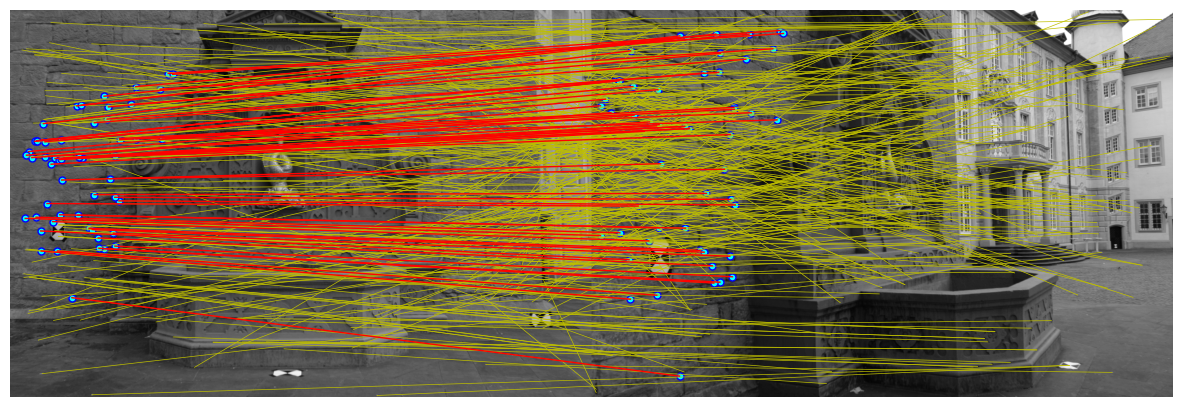

2. Estimating the fundamental matrix...
Estimating the fundamental matrix using the 7-point algorithm...
 - 3 solution(s) found.

Solution 1:
 - Matrix rank: 2 (should be 2)
 - Fundamental Matrix:
[[ 0.00000044  0.00000182 -0.00129949]
 [-0.00000112 -0.00000004  0.00100246]
 [-0.0000619  -0.00188043  1.        ]]


Solution 2:
 - Matrix rank: 2 (should be 2)
 - Fundamental Matrix:
[[ 0.00000101  0.00000382 -0.00258653]
 [-0.00000298 -0.00000007  0.00117035]
 [ 0.00029377 -0.00192762  1.        ]]


Solution 3:
 - Matrix rank: 2 (should be 2)
 - Fundamental Matrix:
[[ 0.00000102  0.00000384 -0.00260063]
 [-0.000003   -0.00000007  0.00117217]
 [ 0.00029768 -0.00192813  1.        ]]

Estimating the fundamental matrix using the 8-point algorithm...
 - Fundamental matrix computed.
 - Matrix rank: 2 (should be 2)
 - Fundamental Matrix:
[[-0.00000002  0.00000022 -0.00027267]
 [ 0.00000037 -0.00000001  0.00087059]
 [-0.00034695 -0.00184362  1.        ]]

3. Visualizing epipolar geometry...


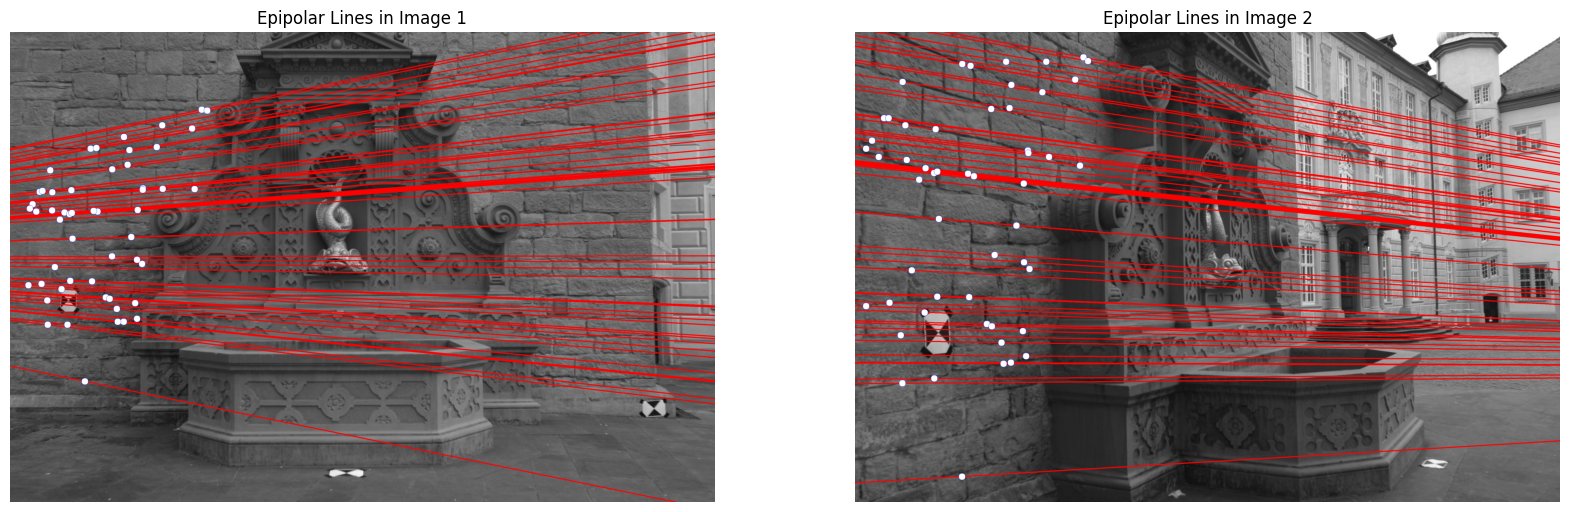

Epipole 1: [-2327.73767119   980.46805285]
Epipole 2: [8346.98603856 1465.67408597]


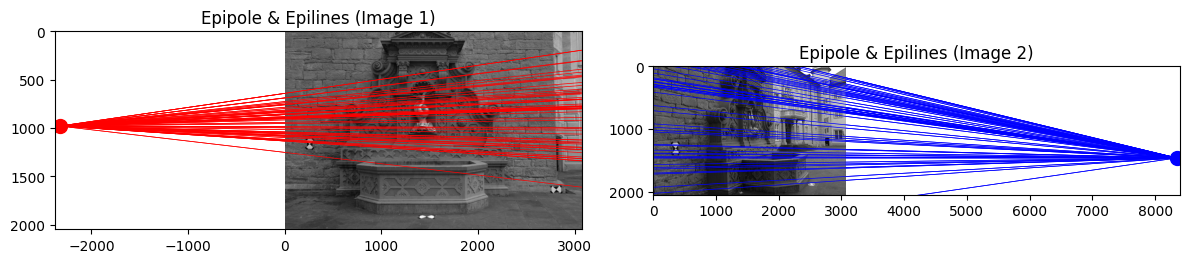

 - Epipolar lines drawn.
4. Computing camera poses...
 - Found 4 possible camera poses:

(array([[ 0.97023582,  0.06131593, -0.2342708 ],
       [ 0.05280855, -0.99770316, -0.04242249],
       [-0.23633389,  0.02878832, -0.97124535]]), array([0.92532504, 0.0620951 , 0.37405584]))


(array([[ 0.97023582,  0.06131593, -0.2342708 ],
       [ 0.05280855, -0.99770316, -0.04242249],
       [-0.23633389,  0.02878832, -0.97124535]]), array([-0.92532504, -0.0620951 , -0.37405584]))


(array([[ 0.53371453, -0.05103903, -0.8441231 ],
       [ 0.04811593,  0.9983928 , -0.02994449],
       [ 0.84429477, -0.02463396,  0.53531254]]), array([0.92532504, 0.0620951 , 0.37405584]))


(array([[ 0.53371453, -0.05103903, -0.8441231 ],
       [ 0.04811593,  0.9983928 , -0.02994449],
       [ 0.84429477, -0.02463396,  0.53531254]]), array([-0.92532504, -0.0620951 , -0.37405584]))

5&6 Selecting the best camera pose using the cheirality condition and Triangulation...
 - Best pose selected.
 - Valid points: 56


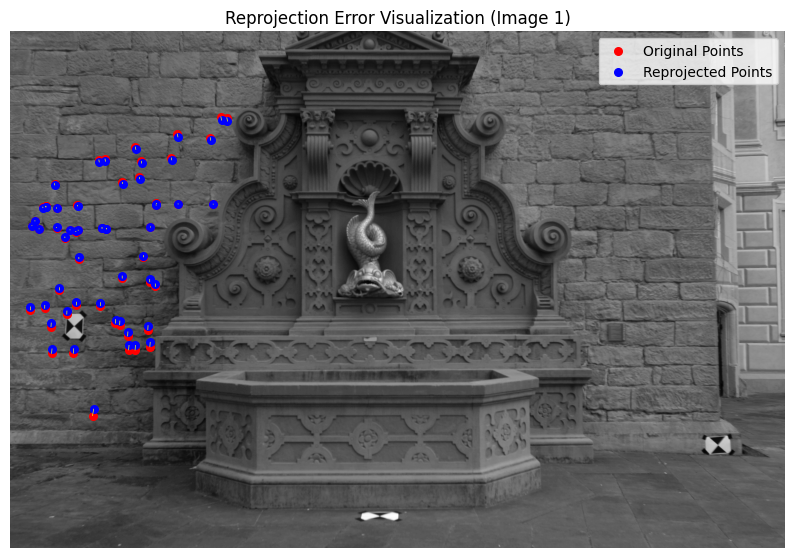

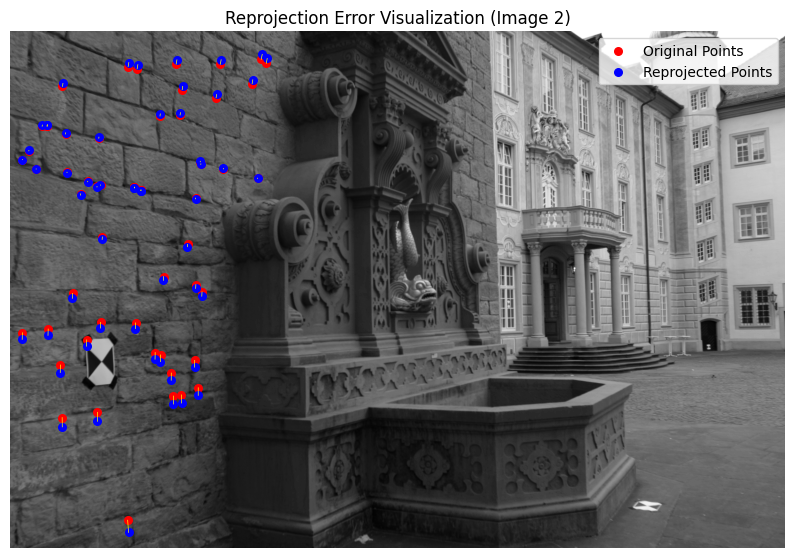

In [3]:
img1 = cv2.imread("data_Q2/first_img.jpg", cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread("data_Q2/second_img.jpg", cv2.IMREAD_GRAYSCALE)
intrinsics = np.loadtxt("data_Q2/intrinsics.txt")

print("1. Extracting and matching features...")
points1, points2, inlier_points1, inlier_points2 = match_features(img1, img2)
print(f" - Total matches found: {len(points1)}")
print(f" - Inliers after RANSAC: {len(inlier_points1)}")
plot_matches(img1, img2, points1, points2, inlier_points1, inlier_points2)

print("2. Estimating the fundamental matrix...")
print(f"Estimating the fundamental matrix using the 7-point algorithm...")
solutions = compute_fundamental_matrix(inlier_points1, inlier_points2, True)
print(f" - {len(solutions)} solution(s) found.")
for idx, F in enumerate(solutions):
    print(f"\nSolution {idx + 1}:")
    print(f" - Matrix rank: {np.linalg.matrix_rank(F)} (should be 2)")
    print(f" - Fundamental Matrix:\n{np.array_str(F/F[2,2], precision=8, suppress_small=True)}\n")
print(f"Estimating the fundamental matrix using the 8-point algorithm...")
F = compute_fundamental_matrix(inlier_points1, inlier_points2, False)
print(" - Fundamental matrix computed.")
print(f" - Matrix rank: {np.linalg.matrix_rank(F)} (should be 2)")
print(f" - Fundamental Matrix:\n{np.array_str(F/F[2,2], precision=8, suppress_small=True)}\n")

print("3. Visualizing epipolar geometry...")
visualize_epipolar_geometry(img1, img2, inlier_points1, inlier_points2, F)
epipole1, epipole2 = compute_epipoles(F)
print(f"Epipole 1: {epipole1}")
print(f"Epipole 2: {epipole2}")
plot_epipoles_and_epilines(img1, img2, inlier_points1, inlier_points2, F)
print(" - Epipolar lines drawn.")

print("4. Computing camera poses...")
poses = get_camera_poses(F, intrinsics)
print(f" - Found {len(poses)} possible camera poses:")
print(f"\n{poses[0]}\n")
print(f"\n{poses[1]}\n")
print(f"\n{poses[2]}\n")
print(f"\n{poses[3]}\n")

print("5&6 Selecting the best camera pose using the cheirality condition and Triangulation...")
R, t, best_points_3d, F_error = select_best_pose_and_validate(
    poses, intrinsics, inlier_points1, inlier_points2, F
)
print(" - Best pose selected.")
print(f" - Valid points: {len(best_points_3d)}")
print(f" - Fundamental matrix validation error: {F_error:.4f}")
print(f" - Best R:\n{R}\n - Best t:\n{t}")

residual_errors = []
for (x1, y1), (x2, y2) in zip(inlier_points1, inlier_points2):
    p1 = np.array([x1, y1, 1]).T
    p2 = np.array([x2, y2, 1]).T
    error = abs(p2.T @ F @ p1)
    residual_errors.append(error)

mean_error = np.mean(residual_errors)
print(f" - Residual mean error: {mean_error:.4f}")

print("7. Visualizing the 3D reconstruction...")
visualize_points(best_points_3d)
print(" - 3D points visualized.")

print("8. Validating Fundamental Matrix...")
print(" - Validating 7-point solutions:")
for idx, F7 in enumerate(solutions):
    error_7pt = validate_fundamental_matrix(F7, inlier_points1, inlier_points2)
    print(f"   Solution {idx + 1} mean error: {error_7pt:.6f}")
error_8pt = validate_fundamental_matrix(F, inlier_points1, inlier_points2)
print(f" - 8-point solution mean error: {error_8pt:.6f}")

print("9. Visualizing 3D reconstruction with camera poses...")
visualize_scene(best_points_3d, R, t)
print(" - 3D points and camera poses visualized.")

print("10. Performing error analysis for two-view geometry...")
P1 = intrinsics @ np.hstack((np.eye(3), np.zeros((3, 1))))
P2 = intrinsics @ np.hstack((R, t.reshape(3, 1)))

print(" - Calculating reprojection errors...")
errors_img1 = calculate_reprojection_error(best_points_3d, inlier_points1, P1)
errors_img2 = calculate_reprojection_error(best_points_3d, inlier_points2, P2)
print(f" - Mean reprojection error (Image 1): {np.mean(errors_img1):.6f}")
print(f" - Mean reprojection error (Image 2): {np.mean(errors_img2):.6f}")
reprojected_points1 = (P1 @ np.hstack((best_points_3d, np.ones((best_points_3d.shape[0], 1)))).T).T
reprojected_points1 /= reprojected_points1[:, 2].reshape(-1, 1)
reprojected_points2 = (P2 @ np.hstack((best_points_3d, np.ones((best_points_3d.shape[0], 1)))).T).T
reprojected_points2 /= reprojected_points2[:, 2].reshape(-1, 1)
plot_reprojected_points(img1, inlier_points1, reprojected_points1[:, :2], "Reprojection Error Visualization (Image 1)")
plot_reprojected_points(img2, inlier_points2, reprojected_points2[:, :2], "Reprojection Error Visualization (Image 2)")

## Theory

### 1> How do you ensure that the matches are accurate, and what thresholding techniques do you apply?
In feature detection and matching, you usually find keypoints with algos like SIFT, or ORB. Matches between these image descriptors are found using methods like brute-force or FLANN, basically trying to find the closest match to a descriptor or sorting it and getting best match. After this, Lowe’s ratio test can be applied to filter unreliable matches by comparing the distance between the best and second-best match for a keypoint. If the ratio of these distances is below a threshold (mostly 0.75), the match can be considered good, otherwise it is discarded. This method can help reduce incorrect matches caused by noise or similar features in the images. Geometric constraints, such as epipolar geometry or homography, can also be used to refine the matches further. Epipolar geometry can ensure that matched points lie along corresponding epipolar lines, while homography can be applied when the images are related by a planar transformation. To handle outliers, RANSAC can be used to estimate transformations like the fundamental matrix. It can randomly select a subset of matches to build a model and then evaluate how well other matches fit this model. Matches that do not fit can be treated as outliers and rejected, leaving more reliable results.

### 2> Explain why normalization is essential in this context.
Normalization is essential in this context because the image coordinates in their original form can cause the A matrix to be ill-conditioned. For example, consider two sets of points:
Image 1: (500, 500), (1000, 1000), (1500, 1500)
Image 2: (300, 300), (800, 800), (1200, 1200)

Without normalization, these coordinates can have a large disparity between their values, with x and y coordinates ranging from 300 to 1500. This leads to a matrix with unevenly scaled values and makes the singular values unreliable, which results in numerical instability when solving for the fundamental matrix.

After normalization, suppose we center the points around their mean and scale them so the average distance from the origin is sqrt(2). This transformation might give:

Normalized Image 1: (0.1, 0.1), (0.2, 0.2), (0.3, 0.3)
Normalized Image 2: (0.05, 0.05), (0.15, 0.15), (0.25, 0.25)

Now, the coordinates are scaled more uniformly, and the condition number of the matrix A improves. This makes the solution to the equations more stable and accurate. After the normalization, the fundamental matrix can be de-normalized back to the original coordinates, leading to a more reliable result.

### 3> What methods can you use to verify that the epipolar lines are accurate?
You can check how well the epipolar lines align with the corresponding points in the images. For each corresponding point in the left image, the epipolar line in the right image should pass through the corresponding point. If you plot the points and the epipolar lines, the points should lie close to the lines. The reprojection error is the distance between the corresponding point and the epipolar line. A small error indicates accurate epipolar geometry.

Also, for each pair of corresponding points (y, y'), you can check whether the constraint (y')^T * F * y = 0 holds. If the fundamental matrix F is accurate, the result should be close to zero for all corresponding points. If the constraint is violated for a particular point pair, it suggests that the fundamental matrix or the epipolar lines are not accurate.

For example, if the epipolar constraint for a pair of corresponding points results in a value close to zero (e.g., 10^-6), it indicates that the points lie on the epipolar line, verifying the accuracy of the epipolar geometry.

Another method is that you can visually check if the epipolar lines are merging in the direction of the other camera.

### 4> What happens to the epipole location if the fundamental matrix is rank-deficient, and how can you simulate this scenario?
If the fundamental matrix is rank-deficient, it means it doesn't fully capture the relationship between two images. This often occurs when the cameras are aligned in the same direction or the points in the images lie on a flat plane. In such cases, the epipole might be at infinity or undefined, as the epipolar lines no longer intersect at a single point and can become parallel instead. You can simulate this by aligning the cameras to have the same optical axis or by using points on a flat plane, where there is little depth difference between the images. The fundamental matrix computed from these points will likely be rank-deficient, and the epipole might not be well-defined. If the points are on a line or flat plane, the fundamental matrix won’t accurately describe the relationship between the images. You can check if the epipole is undefined by examining the epipolar lines; if they are parallel, the epipole may be at infinity. This situation can happen in real life when cameras are nearly parallel or when the scene has little depth variation.

### 5> Explain why there are four possible solutions and how to verify which is the correct one.
When estimating the camera pose from the fundamental matrix, there are four possible solutions because the fundamental matrix encodes the epipolar geometry, which involves both the rotation and translation between the two cameras, and the translation is up to a scale. These two transformations can have multiple configurations that satisfy the constraints given by the epipolar geometry. Specifically, the ambiguity arises from the fact that each camera's pose can be either in front of or behind the scene, leading to different configurations of the camera setup.

To verify which of the four solutions is correct, you can use the cheirality constraint. This constraint ensures that the reconstructed 3D points lie in front of both cameras (i.e., their depths must be positive). By checking the sign of the depth of the points reconstructed from each of the four possible camera poses, you can eliminate the solutions where any of the 3D points lie behind the camera, leaving the correct solution where all points lie in front of both cameras. This step ensures that the solution is physically valid and consistent with the real-world setup.

### 6> Describe how the accuracy of 3D points depends on the quality of the fundamental matrix and camera pose.
The accuracy of 3D points depends significantly on the quality of both the fundamental matrix and the camera pose. The fundamental matrix captures the epipolar geometry between two views, and any errors or inaccuracies in this matrix will propagate into the reconstruction process, leading to less accurate 3D points. If the fundamental matrix is poorly estimated, for instance, due to noise, calibration errors, or insufficient point correspondences, the resulting 3D point reconstruction will be inaccurate or even invalid.

Similarly, the accuracy of the camera pose (which includes both rotation and translation) plays a critical role in determining the accuracy of 3D points. If the camera poses are estimated with errors, the transformation between the views will not align correctly with the true 3D structure of the scene, leading to incorrect depth estimates and positioning of the 3D points. Even small errors in the camera pose can lead to large discrepancies in the reconstructed 3D points, especially in cases where the points are far from the cameras or where the geometry of the scene involves large depth variations.

Thus, both the fundamental matrix and camera pose need to be accurately estimated to ensure that the reconstructed 3D points are reliable. Inaccuracies in either of these components will directly impact the quality of the 3D reconstruction, and methods such as bundle adjustment are often used to refine both parameters to improve the overall accuracy.

### 8> What threshold should you use to determine if a point satisfies the constraint?
To determine if a point satisfies the epipolar constraint when validating a fundamental matrix, you measure the residual error, which is the algebraic distance from a point to its corresponding epipolar line in the other image. The epipolar constraint for a point pair (x, x') is given by:

x'ᵀ F x = 0

where x and x' are the homogeneous coordinates of the points in the two images, and F is the fundamental matrix.

The residual error can be computed as:

error = |x'ᵀ F x|

A threshold for this error is chosen to decide if a point pair satisfies the constraint. The threshold depends on the noise level in the point correspondences. A typical threshold value might range from 1e-3 to 1e-6, depending on the precision of your system and data scale. If the error is below the threshold for a given point pair, it satisfies the constraint; otherwise, it does not.

### 10> How does this error analysis help in refining the camera pose selection?
This error analysis helps refine the camera pose selection by indicating how well the current estimate of the pose matches the true scene geometry. If the reprojection error is large, it suggests that the current camera pose is not accurate, and adjustments are needed. This can guide the optimization process, where minimizing the reprojection error becomes the objective of refining the camera pose. By iteratively adjusting the camera pose to reduce the reprojection error, we move toward the true configuration that best explains the observed 2D points.

Reducing the reprojection error leads to a more accurate camera pose, which results in better 3D reconstructions and improved results in tasks like stereo vision, structure-from-motion, or visual odometry. This process is central to camera calibration and pose estimation techniques, ensuring that the estimated poses align with the true spatial configuration of the scene.